### Environment Setup

In [15]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [16]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Downloading File

In [17]:
dandiset_id = "000021"
dandi_filepath = "sub-716813540/sub-716813540_ses-739448407.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [18]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### The GLM

In [19]:
def neg_log_lik_lnp(theta, X, y):
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  return -log_lik

In [20]:
def fit_lnp(X, y, d=25):
  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"][0], res["x"][1:]

### Synthetic Data

0.0 300.0
6000


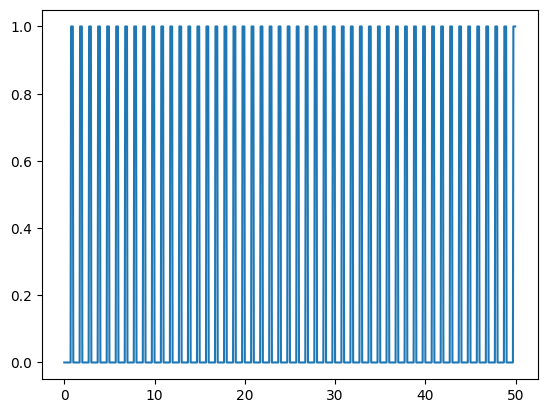

In [21]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

syn_time_axis, syn_flashes = make_flashes(0, 300, [0]*15 + [1]*5, 300)
print(syn_time_axis[0], syn_time_axis[-1])
print(len(syn_flashes))
plt.plot(syn_time_axis[:1000], syn_flashes[:1000])

0.02520134002675578 0.0050000000000000044
6000


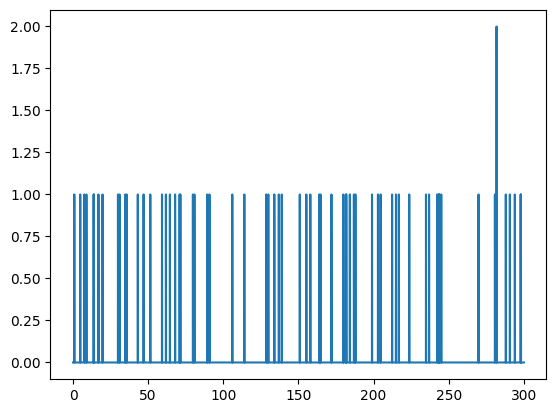

In [22]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff)
    exp_stim = np.exp(weighted_stim) + baseline_rate
    print(np.max(exp_stim), np.min(exp_stim))
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes[1:], weighted_stim, exp_stim
    return spikes

syn_spikes_binned = make_spikes(syn_flashes, -0.995, 0.02)
print(len(syn_spikes_binned))
plt.plot(syn_time_axis, syn_spikes_binned)

### Design Matrix

In [23]:
def build_design_mat(stim, d):
  constant = np.ones_like(stim)

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  design_matrix = np.column_stack([constant, X])
  return design_matrix

(6000, 26)


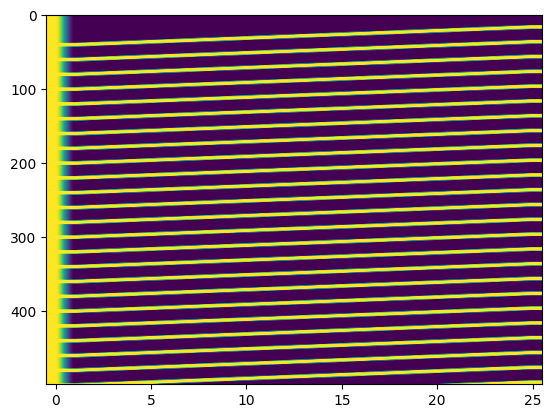

In [24]:
syn_design_mat = build_design_mat(syn_flashes, 25)
print(syn_design_mat.shape)
plt.imshow(syn_design_mat[:500], aspect="auto")

### Running on Synthetic Data

y: (6000,) X: (6000, 26) x0: (26,)
-16.09958272376545


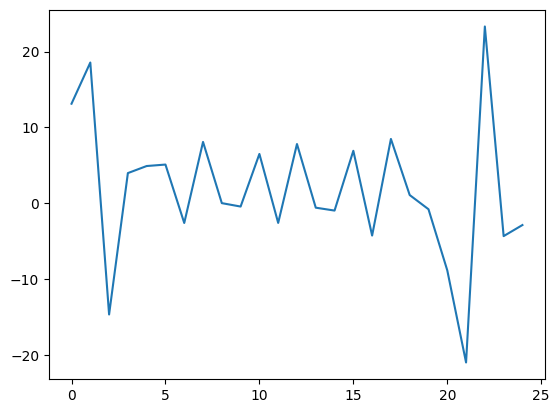

In [25]:
constant, filter = fit_lnp(syn_design_mat, syn_spikes_binned, d=25)
print(constant)
plt.plot(filter)

In [29]:
repeats_vals = []
constant_vals = []
filter1_vals = []
i_vals = []
for i in range(20):
    # n_repeats = 2**i
    n_repeats = 2**11
    time_axis, syn_flashes = make_flashes(0, n_repeats, [0]*80 + [1]*20, n_repeats)
    design_mat = build_design_mat(syn_flashes, d=1)

    for j in range(10):
        syn_spikes_binned = make_spikes(syn_flashes, -0.995, i*0.01)

        constant, filter = fit_lnp(design_mat, syn_spikes_binned, d=1)
        i_vals.append(i)
        repeats_vals.append(n_repeats)
        constant_vals.append(constant)
        filter1_vals.append(filter[0])

0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.0050000000000000044 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.015050167084167954 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.015050167084167954 0.0050000000000000044
y: (204800,) X: (204800, 2) x0: (2,)
0.015050167084167954 0.0050000

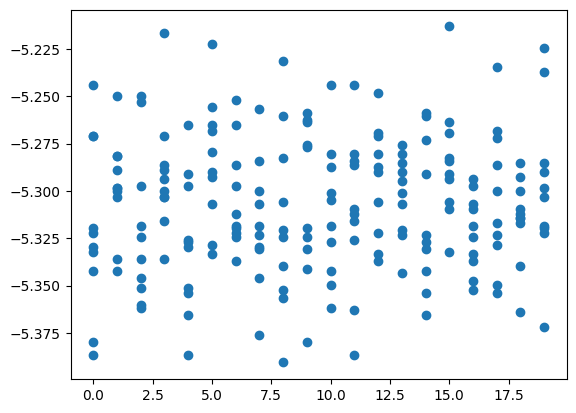

In [31]:
fig, ax = plt.subplots()
# ax.set_xscale("log", base=2)
ax.scatter(i_vals, constant_vals)

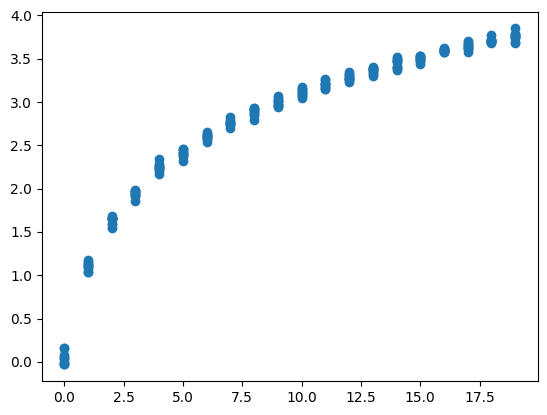

In [32]:
fig, ax = plt.subplots()
# ax.set_xscale("log", base=2)
ax.scatter(i_vals, filter1_vals)

In [33]:
print(np.mean(filter1_vals[-10:]))
print(np.mean(constant_vals[-10:]))

3.757176219314476
-5.297062123447559


### Extracting Exogenous Data

2.0016723489932886


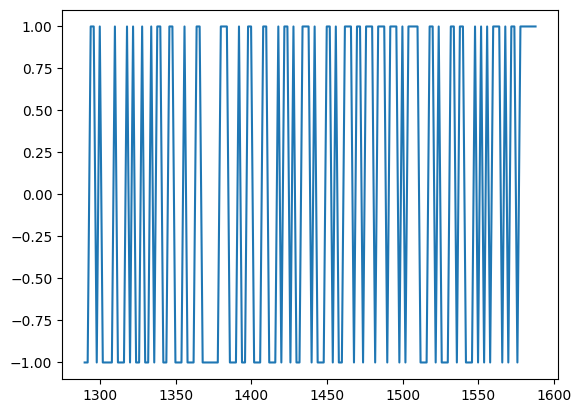

In [34]:
flashes_table = nwb.intervals["flashes_presentations"]
# flashes_table = nwb.intervals["UniqueFFF_presentations"][0:14400:2]
# flashes_table[:10]
flashes_times = [float(start_time) for start_time in flashes_table.start_time]
flashes = [float(color) for color in flashes_table.color]
# flashes = [1.0 if color=="1.0" else 0 for color in flashes_table.color]

print(np.mean(np.diff(flashes_times)))
plt.plot(flashes_times,flashes)

In [35]:
# running_data = np.array(nwb.acquisition["raw_running_wheel_rotation"].data)
# running_timestamps = np.array(nwb.acquisition["raw_running_wheel_rotation"].timestamps)
# plt.plot(running_timestamps, running_data)
running_timestamps = []

### Extracting Spike Data

In [36]:
units = nwb.units

In [37]:
### use the electrodes table to devise a function which maps units to their brain regions

# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

all_regions = set(get_unit_location(row) for row in units)
print(all_regions)

{'', 'grey', 'VISp', 'VISl', 'VIS', 'VISrl', 'VISam'}


In [38]:
### selecting units spike times

# brain_regions = ['VISrl', 'VISal', 'VISpm', 'VISl', 'VISp']
brain_regions = ["VIS", "VISp"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good":
            location_units_spike_times.append(row.spike_times.item())
    units_spike_times += location_units_spike_times

print(len(units_spike_times))

270


### Responsive Units

In [39]:
stim_table = nwb.intervals["flashes_presentations"]
stim_times = []
for i in range(len(stim_table)):
    if i == len(stim_table)-1:
        break
    if float(stim_table.color[i]) == -1.0 and float(stim_table.color[i+1]) == 1.0:
        stim_times.append(stim_table.start_time[i+1])

print(len(stim_times))

40


In [40]:
# bin size for counting spikes
time_resolution = 0.01

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.25
window_end_time = 0.75

In [41]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / time_resolution)

In [42]:
# 3D spike matrix to be populated with spike counts
spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

# populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
for unit_idx in range(n_units):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike at these bin times for this unit on this stim trial
        for bin_idx in bin_indices:
            spike_matrix[unit_idx, bin_idx, stim_idx] += 1

spike_matrix = np.swapaxes(spike_matrix, 1, 2)
spike_matrix.shape

(270, 40, 100)

In [43]:
baseline_rates = np.mean(spike_matrix[:,:,:stimulus_onset_idx], axis=2)
baseline_stds = np.std(spike_matrix[:,:,:stimulus_onset_idx], axis=2)

mean_baseline_rate = np.expand_dims(np.mean(baseline_rates, axis=1), 1)
mean_baseline_stds = np.expand_dims(np.mean(baseline_stds, axis=1), 1) + 0.0001

zscores = (np.mean(spike_matrix, axis=1) - mean_baseline_rate) / mean_baseline_stds
max_zscores = np.max(zscores[:,stimulus_onset_idx:],axis=1)
# plt.imshow(zscores, vmin=-5, vmax=5)

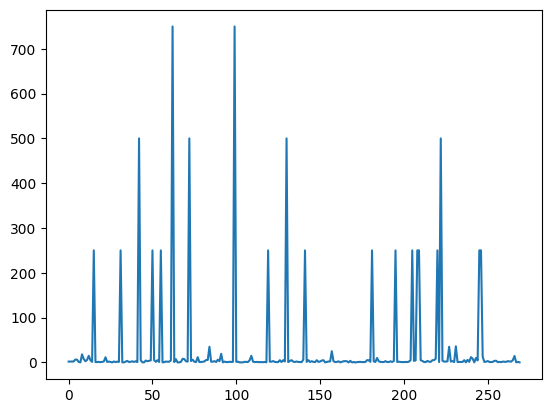

In [44]:
plt.plot(max_zscores)

In [45]:
units_spike_times = np.array(units_spike_times)
selected_units_spike_times = units_spike_times[max_zscores > 10]
print(len(selected_units_spike_times))

33


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\3710468762.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  units_spike_times = np.array(units_spike_times)


### Aligning Data

In [46]:
bin_sz = 0.05

start_time = max(min([min(times) for times in selected_units_spike_times]), np.min(flashes_times))
end_time = min(max([max(times) for times in selected_units_spike_times]), np.max(flashes_times))
time_axis = np.linspace(start_time, end_time, num=int((end_time-start_time)//bin_sz), endpoint=False)

print("start:",start_time,"end:",end_time)
print(len(time_axis))

start: 1289.6710299899025 end: 1587.9202099899026
5964


5964


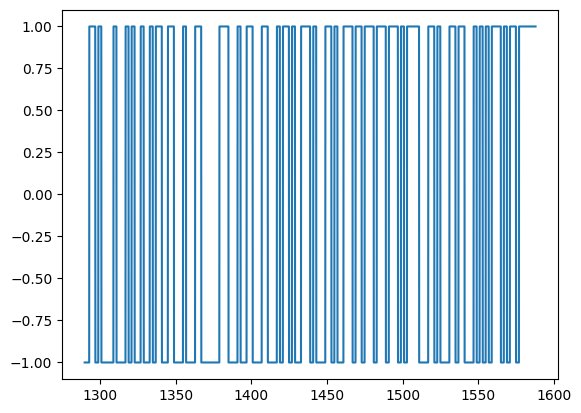

In [47]:
f = interpolate.interp1d(flashes_times, flashes, axis=0, kind="nearest", fill_value="extrapolate")
interp_flashes = f(time_axis)
print(len(interp_flashes))
plt.plot(time_axis, interp_flashes)

In [48]:
# f = interpolate.interp1d(running_timestamps, running_data, axis=0, kind="linear", fill_value="extrapolate")
# interp_running = f(time_axis)
# norm_running = interp_running / np.max(np.abs(interp_running))
# print(len(norm_running))
# plt.plot(time_axis, norm_running)

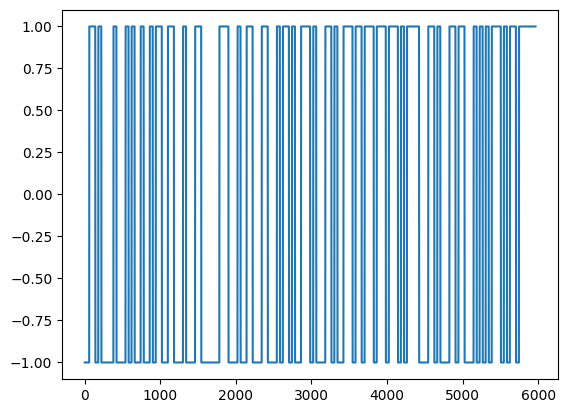

In [49]:
mod_coef = 0.5
# exog = (1-mod_coef)*interp_flashes + mod_coef*norm_running
exog = interp_flashes
plt.plot(exog)

### Generating Filters

(5964, 101)


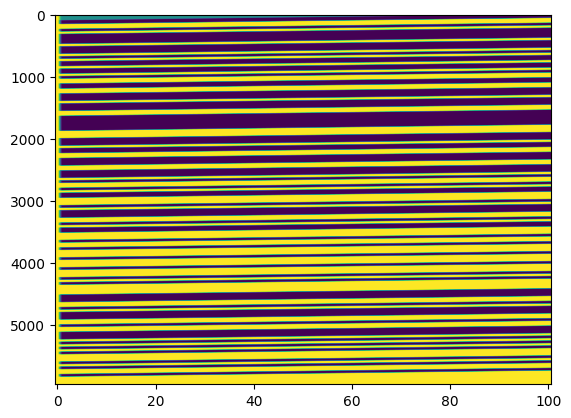

In [71]:
filter_length = 100
design_mat = build_design_mat(interp_flashes, d=filter_length)
print(design_mat.shape)
plt.imshow(design_mat, aspect="auto")

In [72]:
filters = []
constants = []
# fig, axes = plt.subplots(1,3)
for i, spike_times in enumerate(selected_units_spike_times):
    # bin spikes where bins line up with the interpolated flashes timestamps
    these_spikes_binned, _ = np.histogram(spike_times, bins=len(time_axis), range=(start_time,end_time))
    # axes[i].plot(these_spikes_binned)
    try:
        const, filt = fit_lnp(design_mat, these_spikes_binned, d=filter_length)
        filters.append(filt)
        constants.append(const)
    except:
        filters.append([])
        constants.append(np.nan)

y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppDa

y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppDa

y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykern

y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()


y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()


y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:3: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_14652\250335814.py:4: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()


y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)
y: (5964,) X: (5964, 101) x0: (101,)


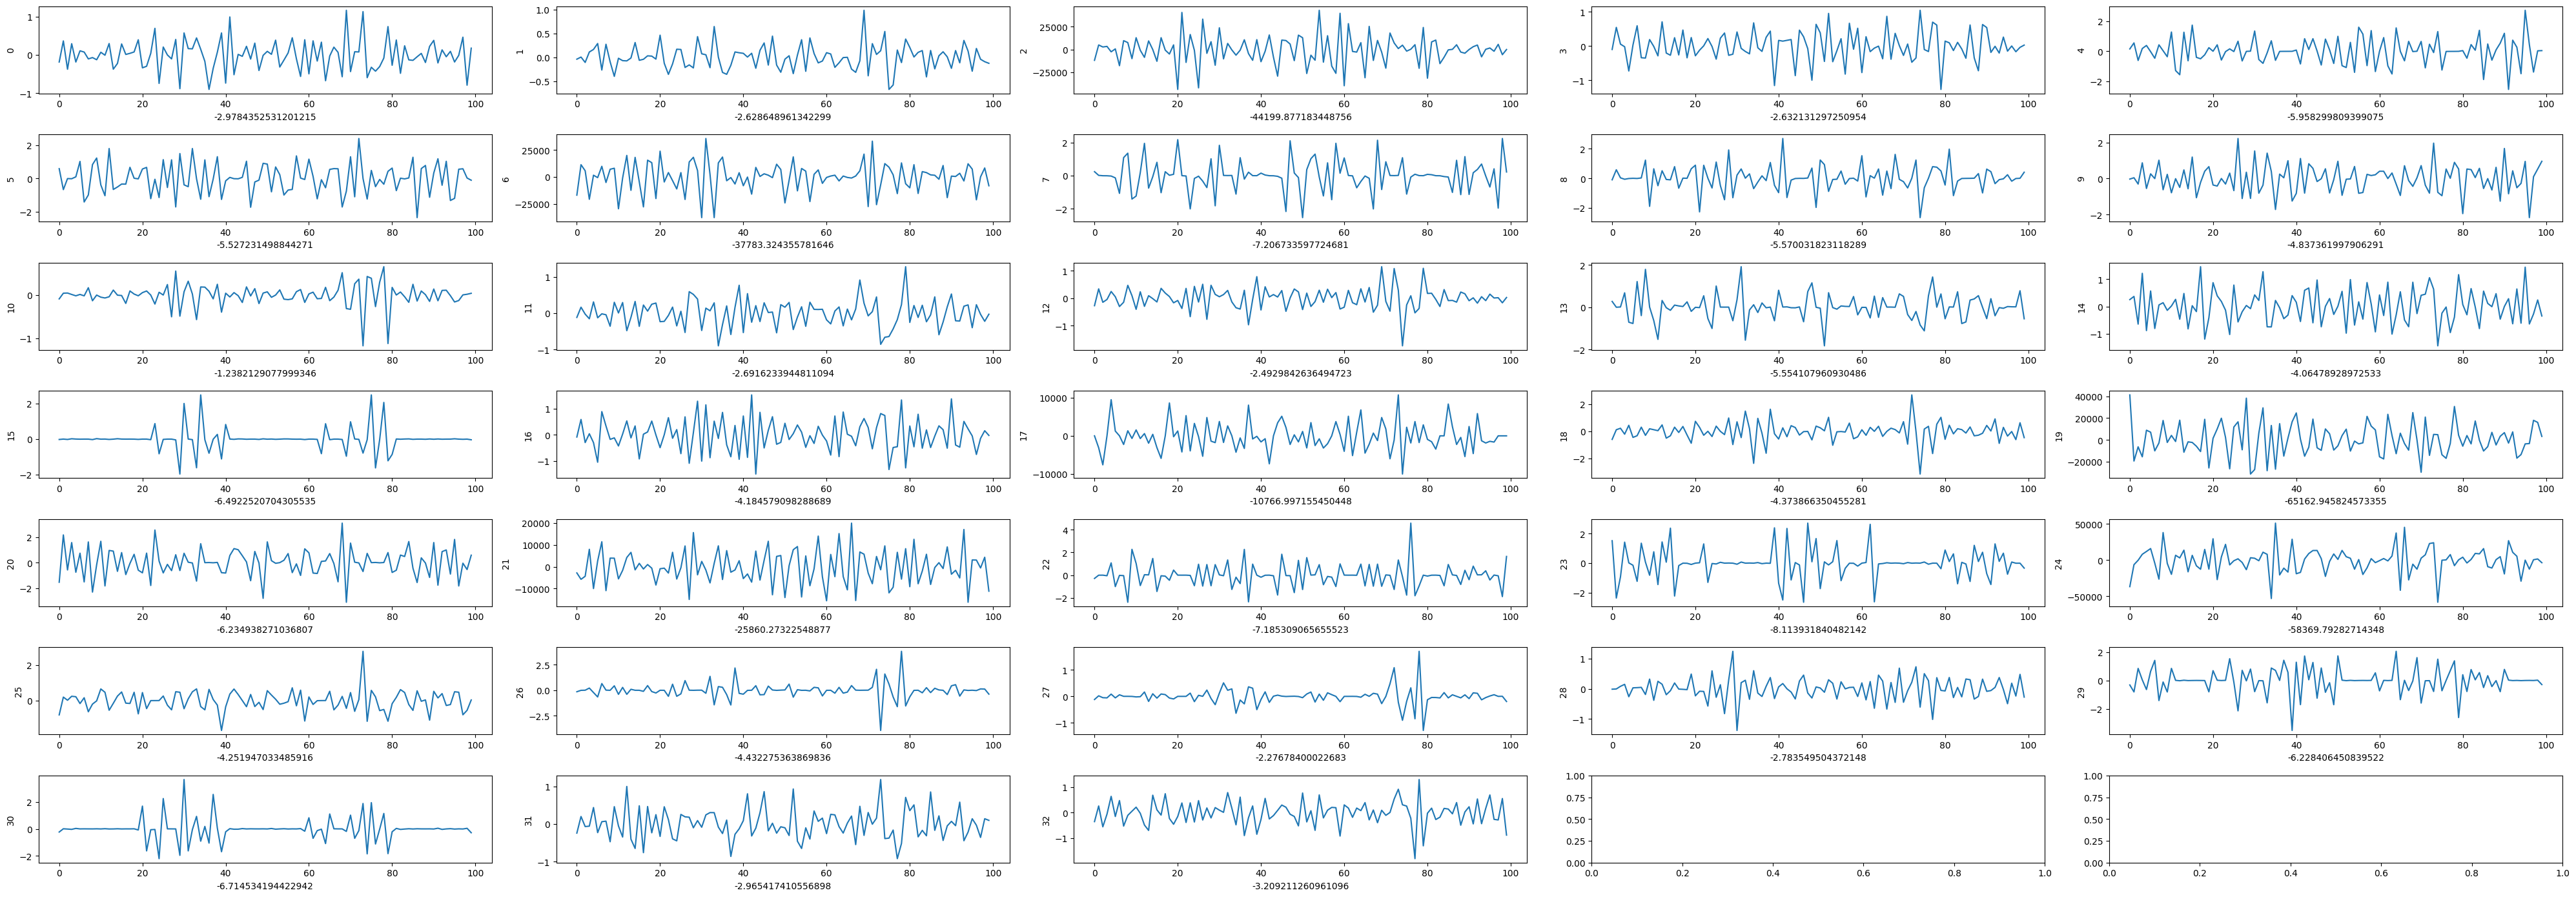

In [73]:
n_cols=5

n_rows = ceil(len(filters)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40,2*n_rows))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i in range(len(filters)):
    f = filters[i]
    c = constants[i]
    row = i // n_cols
    col = i % n_cols
    axes[row][col].plot(f)
    axes[row][col].set_ylabel(i)
    axes[row][col].set_xlabel(c)

fig.tight_layout()
plt.show()

In [53]:
unit_idx = 134
spike_times = units_spike_times[unit_idx]
print(spike_times)

[5.86701842e-01 8.92868551e-01 2.02853538e+00 ... 9.26837904e+03
 9.26841657e+03 9.26845164e+03]


In [54]:
num_spikes = len(time_axis)
# spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, time_axis)

### Predict Activity

In [ ]:
ntfilt = 1
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)
design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

res = fit_lnp(design_mat_offset, spikes_binned, bin_sz=0.01, lam=0)
constant, filter = res[0], res[1:]
print(constant, filter)

NameError: name 'get_design_mat' is not defined

In [ ]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

In [ ]:
### predict
predictions = []
for j in range(100):
    predictions.append(predict_spikes(design_mat, filter, constant))

In [ ]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [ ]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))